## Helper Methods
- Tools we may use later for data pre-processing and graphing

In [56]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
from pathlib import Path
import os
import sys
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Conv2D, MaxPooling2D, concatenate, Lambda, BatchNormalization, Activation, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, mean_squared_error
import matplotlib.pyplot as plt 
from collections.abc import Sequence
from sklearn import preprocessing
%matplotlib inline
from IPython.display import Image
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preproc
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline

BASE_PATH = "./"

# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Regression chart.
def chart_regression(pred,y,sort = True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by = ['y'],inplace = True)
    a = plt.plot(t['pred'].tolist(), ls = '', marker='s', markersize = 1.0, label = 'prediction', color = 'orange')
    b = plt.plot(t['y'].tolist(), label = 'expected', color = 'blue')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
#custom function for sliding window x/y data split
def create_sliding_window_data(df, close_unnormalized, window_size):
    x = []
    y = []
    for i in range(window_size, len(df)):
        #get window_size days of data (rows i-window_size to i-1)
        window = df.iloc[i-window_size:i].values
        x.append(window.flatten())
        y.append(close_unnormalized[i])
    return np.array(x), np.array(y)


## Set up Environment
Create test output folders and define paths 

In [57]:
base_path=os.path.join(os.getcwd(), './test-output/')

iteration='iteration-2'
full_path = os.path.join(base_path, iteration)
try:
        os.mkdir(base_path)
except Exception as e:
     print(f"Probably safe to ignore the following error: \n{e}")

#try:
#    os.mkdir(full_path)
#except Exception as e:
#    print(f"{e}\nExiting to protect previous work.")
#    sys.exit(0)
    

Probably safe to ignore the following error: 
[Errno 17] File exists: '/Users/nyess/Desktop/VSCode/Python/Assignment4/bchurch2-Time-Series-Forecasting/./test-output/'


## Data Extraction

In [58]:
#read dataset and format
from sklearn.model_selection import train_test_split
TXT_DATASET_LOCATION = "./business-dataset/RDS-B.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)




split_raw = int(len(df) * 0.7)
df_train = df.iloc[:split_raw].copy()
df_test  = df.iloc[split_raw:].copy()



train_means = {}
train_stds  = {}

for col in df_train.columns:
    mean = df_train[col].mean()
    sd   = df_train[col].std()
    train_means[col] = mean
    train_stds[col]  = sd

    # normalize TRAIN in place
    encode_numeric_zscore(df_train, col, mean=mean, sd=sd)
    # normalize TEST using the same mean/sd (no leakage)
    encode_numeric_zscore(df_test, col, mean=mean, sd=sd)

window_size = 7

# keep separate unnormalized close values for each split
close_train = df["Close"].iloc[:split_raw].values.copy()
close_test  = df["Close"].iloc[split_raw:].values.copy()

x_train, y_train = create_sliding_window_data(df_train, close_train, window_size)
x_test,  y_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#code no bueno
#for col in df.columns:
   # encode_numeric_zscore(df, col) 

#fix to lstm issue where test data starts cold


## Data Split

In [59]:
#XY split
'''
from sklearn.model_selection import train_test_split
x, y = create_sliding_window_data(df, close_unnormalized, window_size=7)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, shuffle=False, random_state=42
) '''

window_size = 7
n_features = 5

#creating split for each model 
#Base aka FCNN
x_train_flat, y_train_base = x_train.copy(), y_train.copy()
x_test_flat, y_test_base = x_test.copy(), y_test.copy()

x_train_cnn = x_train.reshape(-1, 7, 5, 1)
x_test_cnn = x_test.reshape(-1, 7, 5, 1)

#for LSTM (3D) 
x_train_lstm = x_train.reshape(-1, 7, 5)
x_test_lstm = x_test.reshape(-1, 7, 5)



## LSTM Model

In [60]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
#save the best model
window_size = 7
n_features = 5

# Reshape for LSTM
#x = x.reshape(-1, window_size, n_features)

#LSTM checkpoint
LSTMcheckpointer = ModelCheckpoint(filepath=full_path + "/best_LSTMweights.keras", monitor="val_loss", save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(5):
    print(i)
    #build the network
    LSTM_model = Sequential()

    LSTM_model.add(Bidirectional((LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, input_shape=(window_size, n_features)))))
   # LSTM_model.add(Dropout(0.3))
    LSTM_model.add(LSTM(32, return_sequences=False, dropout=0.1, recurrent_dropout=0.0))
    LSTM_model.add(Dense(32, activation="tanh"))
    LSTM_model.add(Dropout(0.1))
    LSTM_model.add(Dense(1))
   

    #model compilation
    LSTM_model.compile(loss = 'mean_squared_error', optimizer = Adam(1e-3))
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1, mode="auto")
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model



# Train correct model
history = LSTM_model.fit(
    x_train_lstm, y_train_base,
    validation_data=(x_test_lstm, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=True,
    callbacks=[LSTMcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
1
2
3
4
Epoch 1/1000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 968.2055 - val_loss: 3017.7693
Epoch 2/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 708.4315 - val_loss: 2637.6602
Epoch 3/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 584.7603 - val_loss: 2314.2292
Epoch 4/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 486.3083 - val_loss: 2037.8828
Epoch 5/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 408.2859 - val_loss: 1798.2061
Epoch 6/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 342.2265 - val_loss: 1587.5154
Epoch 7/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 288.2334 - val_loss: 1402.6864
Epoch 8/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 242.7006 - val_loss: 1237.8479
Epoch 9/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 202.3567 - val_loss: 1093.6167
Epoch 10/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 169.8837 - val_loss: 966.4922
Epoch 11/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 142.5963 - val_loss:

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Score (RMSE): 7.2646742575863215


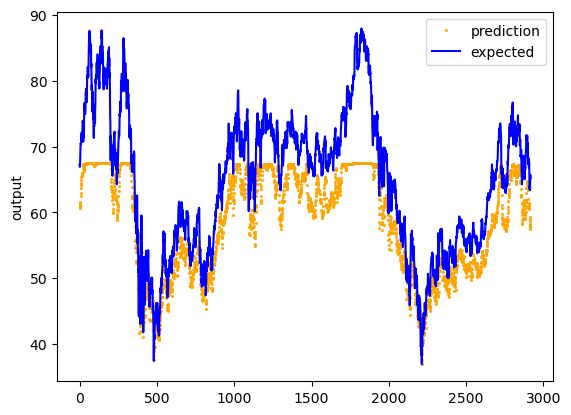

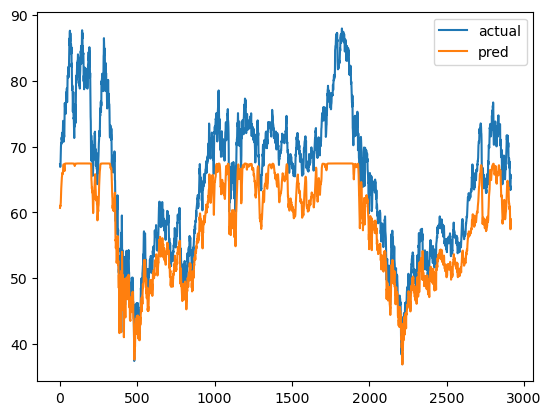

(2917, 1)


In [61]:
LSTM_model.load_weights(full_path + '/best_LSTMweights.keras')
y_pred_lstm= LSTM_model.predict(x_test_lstm)

#rmse score
rmse = np.sqrt(metrics.mean_squared_error(y_test_base,y_pred_lstm))
print("Score (RMSE): {}".format(rmse))
chart_regression(y_pred_lstm.flatten(),y_test_base, sort = False)

plt.plot(y_test_base, label="actual")
plt.plot(y_pred_lstm.flatten(), label="pred")
plt.legend(); plt.show()
print(y_pred_lstm.shape)


## FCNN Model


In [62]:
#save the best model
checkpointer = ModelCheckpoint(filepath= full_path + "/best_FCNNweights1.keras", verbose = 0, save_best_only = True) 
#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network
    model = Sequential()
    model.add(Dense(64, input_dim = x_train_flat.shape[1], activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation = "relu"))
    model.add(Dense(1, activation = "linear"))
   

    #model compilation
    model.compile(loss = 'mean_squared_error', optimizer = optimizer)
    #early stopping
    monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
    #optimizer
    optimizer = Adam(learning_rate = 0.0001)

    #train model
    history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 190, batch_size = 64, shuffle=True, callbacks = [monitor, checkpointer], verbose = 1)
    print('Training finished...Loading the best model')  
    print()

    

0
Epoch 1/190


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1305.5829 - val_loss: 4201.8823
Epoch 2/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - loss: 1252.7950 - val_loss: 3933.8381
Epoch 3/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 1127.1771 - val_loss: 3192.1704
Epoch 4/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 870.4919 - val_loss: 1969.7362
Epoch 5/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 551.4301 - val_loss: 733.2442
Epoch 6/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 299.8961 - val_loss: 141.1091
Epoch 7/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 199.4332 - val_loss: 110.7055
Epoch 8/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 181.9060 - val_loss: 152.4507
Epoch 9/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 535us/step - loss: 177.0026 - val_loss: 149.6726
Epoch 10/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 175.6121 - val_loss: 151.2260
Epoch 11/190
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 173.4562 - v

In [63]:
model.load_weights(full_path + '/best_FCNNweights1.keras')

## FCNN Graphing

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 366us/step
(2917, 1)
Score (RMSE): 10.521669388574194


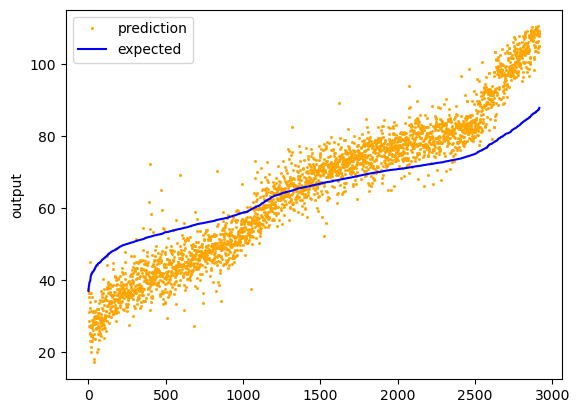

In [64]:
#make predictions
y_pred = model.predict(x_test_flat)
print(y_pred.shape)

#rmse score
rmse = np.sqrt(metrics.mean_squared_error(y_test_base, y_pred))
print("Score (RMSE): {}".format(rmse))
chart_regression(y_pred.flatten(),y_test_base, sort = True)

In [65]:
x_train.shape

(6813, 35)

## CNN Model


In [66]:

#save the best model
CNNcheckpointer = ModelCheckpoint(filepath= full_path + "/best_CNNweights.keras", verbose = 0, save_best_only = True) 

#reshape for CNN
#Not certain if this is the best approach, mainly just done to avoid error
#need to not do this lol

#optimizer definition (Adam)
optimizer = Adam(learning_rate = 0.0001)
for i in range(1):
    print(i)
    #build the network

    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',
                        input_shape=(7, 5, 1)))
    CNN_model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
    CNN_model.add(MaxPooling2D(pool_size=(2, 2)))
    CNN_model.add(Dropout(0.25))

    CNN_model.add(Flatten())
    CNN_model.add(Dense(64, activation="relu"))
    CNN_model.add(Dropout(0.25))
    CNN_model.add(Dense(1, activation="linear"))
    

#model compilation
CNN_model.compile(loss = 'mean_squared_error', optimizer = optimizer)
#early stopping
monitor = EarlyStopping(monitor = 'val_loss', patience = 7, restore_best_weights = True, verbose = 1)
#optimizer
optimizer = Adam(learning_rate = 0.0001)

#train model

#Train correct model
history = CNN_model.fit(
    x_train_cnn, y_train_base,
    validation_data=(x_test_cnn, y_test_base),
    epochs=1000,
    batch_size=64,
    shuffle=True,
    callbacks=[CNNcheckpointer, monitor],
    verbose=1
)
print('Training finished...Loading the best model')  
print()


0
Epoch 1/1000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


107/107 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1239.6206 - val_loss: 3512.7063
Epoch 2/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 757.4636 - val_loss: 306.4106
Epoch 3/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183.1986 - val_loss: 456.0240
Epoch 4/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138.7303 - val_loss: 344.4112
Epoch 5/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120.2128 - val_loss: 215.0076
Epoch 6/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100.6441 - val_loss: 133.9893
Epoch 7/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83.0661 - val_loss: 79.9911
Epoch 8/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.3589 - val_loss: 42.6288
Epoch 9/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51.3167 - val_loss: 33.0050
Epoch 10/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41.9374 - val_loss: 36.4398
Epoch 11/1000
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36.4556 - val_loss: 43.7233
Epoch 1

92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step
(2917, 1)
Score (RMSE): 5.744995537802426


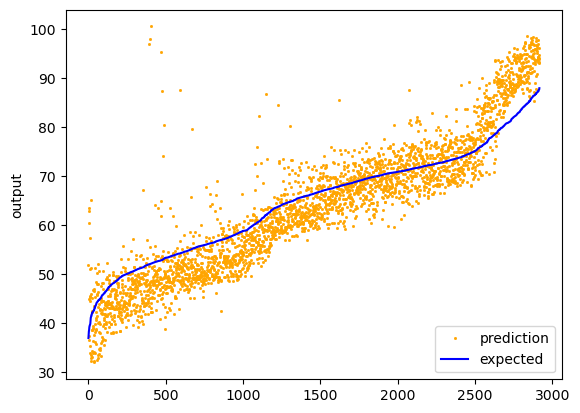

In [67]:
CNN_model.load_weights(full_path + '/best_CNNweights.keras')
y_other_pred = CNN_model.predict(x_test_cnn)
print(y_other_pred.shape)

#rmse score
score = np.sqrt(metrics.mean_squared_error(y_test_base,y_other_pred))
print("Score (RMSE): {}".format(score))
chart_regression(y_other_pred.flatten(),y_test_base, sort = True)


In [68]:
x_train[1:4]

array([[-1.16616576, -1.16716525, -1.17271889, -0.53871579, -1.16664   ,
        -1.16378738, -1.16244652, -1.16312804, -0.5517051 , -1.16307366,
        -1.16259811, -1.16126683, -1.16312804, -0.55383767, -1.16426249,
        -1.16973332, -1.17070424, -1.17511659, -0.53774644, -1.17377259,
        -1.17330097, -1.17424332, -1.18111087, -0.55868443, -1.18209391,
        -1.18043618, -1.178962  , -1.17991204, -0.51971651, -1.17852761,
        -1.17330097, -1.17070424, -1.17271889, -0.55383767, -1.17377259],
       [-1.16378738, -1.16244652, -1.16312804, -0.5517051 , -1.16307366,
        -1.16259811, -1.16126683, -1.16312804, -0.55383767, -1.16426249,
        -1.16973332, -1.17070424, -1.17511659, -0.53774644, -1.17377259,
        -1.17330097, -1.17424332, -1.18111087, -0.55868443, -1.18209391,
        -1.18043618, -1.178962  , -1.17991204, -0.51971651, -1.17852761,
        -1.17330097, -1.17070424, -1.17271889, -0.55383767, -1.17377259,
        -1.18519295, -1.18604006, -1.18950289, -0.

## EC: RMSE Against N Value
Using the FCNN

In [69]:
#read dataset and format
from sklearn.model_selection import train_test_split
TXT_DATASET_LOCATION = "./business-dataset/RDS-B.csv"
df = pd.read_csv(TXT_DATASET_LOCATION)

#drop extra columns, reorder
df.drop(['Date','Adj Close'], axis=1, inplace=True)
df = df[["Open","High","Low","Volume","Close"]]

#remove NaN values
df = df.dropna() 

#keep copy before normalization
close_unnormalized = df['Close'].values.copy()

#reset index after dropping rows
df = df.reset_index(drop=True)

#split data 
split_raw = int(len(df) * 0.7)
df_train = df.iloc[:split_raw].copy()
df_test  = df.iloc[split_raw:].copy()

train_means = {}
train_stds  = {}

for col in df_train.columns:
    mean = df_train[col].mean()
    sd   = df_train[col].std()
    train_means[col] = mean
    train_stds[col]  = sd

    # normalize TRAIN in place
    encode_numeric_zscore(df_train, col, mean=mean, sd=sd)
    # normalize TEST using the same mean/sd (no leakage)
    encode_numeric_zscore(df_test, col, mean=mean, sd=sd)

# keep separate unnormalized close values for each split
close_train = df["Close"].iloc[:split_raw].values.copy()
close_test  = df["Close"].iloc[split_raw:].values.copy()

#normalize data (separate from close_unnormalized)
for col in df.columns:
    encode_numeric_zscore(df, col)

### Window size 3

In [70]:
#save the best model across all iterations
checkpointer = ModelCheckpoint(filepath="dnn/best_FCNNweights2.keras", verbose=0, save_best_only=True) 

#window size 3
window_size = 3
x1_train, y1_train = create_sliding_window_data(df_train, close_train, window_size)
x1_test,  y1_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss1 = np.inf
best_model_weights1 = None
best_iteration1 = 0

for i in range(10):
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model1 = Sequential()
    model1.add(Dense(64, input_dim=x1_train.shape[1], activation="relu"))
    model1.add(Dropout(0.3))
    model1.add(Dense(32, activation="relu"))
    model1.add(Dropout(0.2))
    model1.add(Dense(16, activation="relu"))
    model1.add(Dense(1, activation="linear"))
    
    #model compilation
    model1.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history1 = model1.fit(x1_train, y1_train, validation_data=(x1_test, y1_test), 
                         epochs=1000, batch_size=64, shuffle=True,
                         callbacks=[monitor, checkpointer], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss1 = min(history1.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss1 < best_val_loss1:
        best_val_loss1 = current_val_loss1
        best_model_weights1 = model1.get_weights()
        best_iteration1 = i + 1
    
    print()

#save the best model weights from all iterations
model1.set_weights(best_model_weights1)
model1.save("dnn/best_FCNNweights2_overall.keras")


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Window size 5

In [71]:
#save the best model across all iterations
checkpointer2 = ModelCheckpoint(filepath="dnn/best_FCNNweights3.keras", verbose=0, save_best_only=True) 

#window size 5
window_size = 5
x2_train, y2_train = create_sliding_window_data(df_train, close_train, window_size)
x2_test,  y2_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss2 = np.inf
best_model_weights2 = None
best_iteration2 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model2 = Sequential()
    model2.add(Dense(64, input_dim=x2_train.shape[1], activation="relu"))
    model2.add(Dropout(0.3))
    model2.add(Dense(32, activation="relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(16, activation="relu"))
    model2.add(Dense(1, activation="linear"))
    
    #model compilation
    model2.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history2 = model2.fit(x2_train, y2_train, validation_data=(x2_test, y2_test), 
                         epochs=1000, batch_size=64, shuffle=True,
                         callbacks=[monitor, checkpointer2], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss2 = min(history2.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss2 < best_val_loss2:
        best_val_loss2 = current_val_loss2
        best_model_weights2 = model2.get_weights()
        best_iteration2 = i + 1
print()

#save the best model weights from all iterations
model2.set_weights(best_model_weights2)
model2.save("dnn/best_FCNNweights3_overall.keras")

### Window size 7

In [72]:
#save the best model across all iterations
checkpointer3 = ModelCheckpoint(filepath="dnn/best_FCNNweights4.keras", verbose=0, save_best_only=True) 

#window size 7
window_size = 7
x3_train, y3_train = create_sliding_window_data(df_train, close_train, window_size)
x3_test,  y3_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss3 = np.inf
best_model_weights3 = None
best_iteration3 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model3 = Sequential()
    model3.add(Dense(64, input_dim=x3_train.shape[1], activation="relu"))
    model3.add(Dropout(0.3))
    model3.add(Dense(32, activation="relu"))
    model3.add(Dropout(0.2))
    model3.add(Dense(16, activation="relu"))
    model3.add(Dense(1, activation="linear"))
    
    #model compilation
    model3.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history3 = model3.fit(x3_train, y3_train, validation_data=(x3_test, y3_test), 
                         epochs=1000, batch_size=64, shuffle=True,
                         callbacks=[monitor, checkpointer3], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss3 = min(history3.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss3 < best_val_loss3:
        best_val_loss3 = current_val_loss3
        best_model_weights3 = model3.get_weights()
        best_iteration3 = i + 1
print()

#save the best model weights from all iterations
model3.set_weights(best_model_weights3)
model3.save("dnn/best_FCNNweights4_overall.keras")


### Window size 9

In [73]:
#save the best model across all iterations
checkpointer4 = ModelCheckpoint(filepath="dnn/best_FCNNweights5.keras", verbose=0, save_best_only=True) 

#window size 9
window_size = 9
x4_train, y4_train = create_sliding_window_data(df_train, close_train, window_size)
x4_test,  y4_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss4 = np.inf
best_model_weights4 = None
best_iteration4 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model4 = Sequential()
    model4.add(Dense(64, input_dim=x4_train.shape[1], activation="relu"))
    model4.add(Dropout(0.3))
    model4.add(Dense(32, activation="relu"))
    model4.add(Dropout(0.2))
    model4.add(Dense(16, activation="relu"))
    model4.add(Dense(1, activation="linear"))
    
    #model compilation
    model4.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history4 = model4.fit(x4_train, y4_train, validation_data=(x4_test, y4_test), 
                         epochs=1000, batch_size=64, shuffle=True,
                         callbacks=[monitor, checkpointer4], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss4 = min(history4.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss4 < best_val_loss4:
        best_val_loss4 = current_val_loss4
        best_model_weights4 = model4.get_weights()
        best_iteration4 = i + 1
print()

#save the best model weights from all iterations
model4.set_weights(best_model_weights4)
model4.save("dnn/best_FCNNweights5_overall.keras")

### Window size 11

In [74]:
#save the best model across all iterations
checkpointer5 = ModelCheckpoint(filepath="dnn/best_FCNNweights6.keras", verbose=0, save_best_only=True) 

#window size 11
window_size = 11
x5_train, y5_train = create_sliding_window_data(df_train, close_train, window_size)
x5_test,  y5_test  = create_sliding_window_data(df_test,  close_test,  window_size)

#track the best validation loss across all iterations
best_val_loss5 = np.inf
best_model_weights5 = None
best_iteration5 = 0
for i in range(10):
    
    #optimizer definition (Adam)
    optimizer = Adam(learning_rate=0.0001)
    
    #early stopping callback
    monitor = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=0)
    
    #model definition
    model5 = Sequential()
    model5.add(Dense(64, input_dim=x5_train.shape[1], activation="relu"))
    model5.add(Dropout(0.3))
    model5.add(Dense(32, activation="relu"))
    model5.add(Dropout(0.2))
    model5.add(Dense(16, activation="relu"))
    model5.add(Dense(1, activation="linear"))
    
    #model compilation
    model5.compile(loss='mean_squared_error', optimizer=optimizer)
    
    #train model
    history5 = model5.fit(x5_train, y5_train, validation_data=(x5_test, y5_test), 
                         epochs=1000, batch_size=64, shuffle=True,
                         callbacks=[monitor, checkpointer5], verbose=0)
    
    #get the best validation loss from this iteration
    current_val_loss5 = min(history5.history['val_loss'])
    
    #check if this is the best model so far
    if current_val_loss5 < best_val_loss5:
        best_val_loss5 = current_val_loss5
        best_model_weights5 = model5.get_weights()
        best_iteration5 = i + 1
print()

#save the best model weights from all iterations
model5.set_weights(best_model_weights5)
model5.save("dnn/best_FCNNweights6_overall.keras")

Window Size: 3
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 377us/step
(2921, 1)
Score (RMSE): 2.206050682237555
Window Size: 5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step
(2919, 1)
Score (RMSE): 8.538948182741551
Window Size: 7
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 490us/step
(2917, 1)
Score (RMSE): 3.6688773731429443
Window Size: 9
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step
(2915, 1)
Score (RMSE): 1.9190809975606467
Window Size: 11
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
(2913, 1)
Score (RMSE): 3.6242921340500165


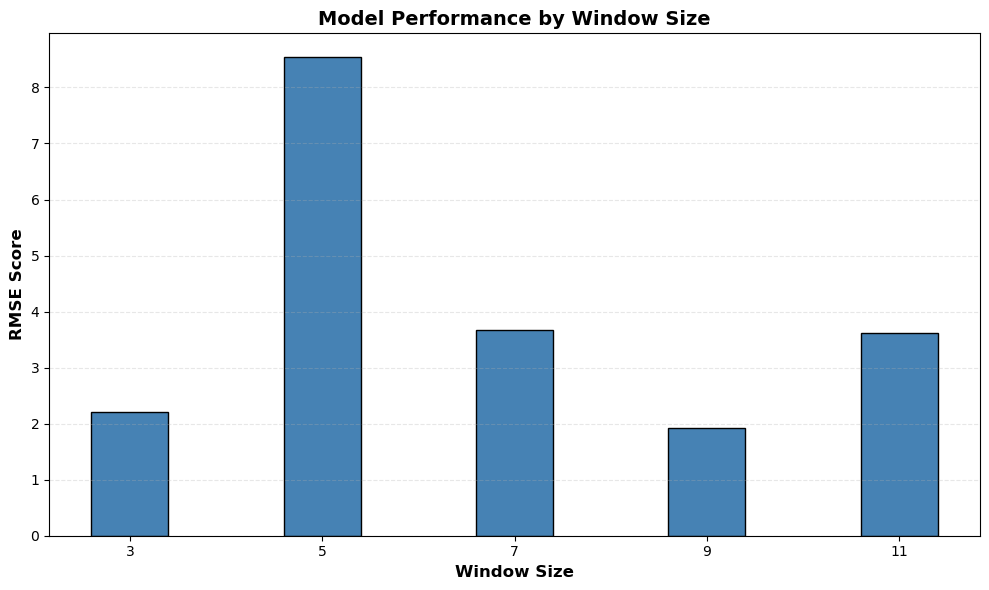

SUMMARY
Best Window Size: 9
Best RMSE Score: 1.9191

All RMSE Scores:
  Window Size 3: 2.2061
  Window Size 5: 8.5389
  Window Size 7: 3.6689
  Window Size 9: 1.9191
  Window Size 11: 3.6243


In [75]:
#stored weights and models
window_sizes = [3, 5, 7, 9, 11]
models = [model1, model2, model3, model4, model5]
weight_files = [
    'dnn/best_FCNNweights2_overall.keras',
    'dnn/best_FCNNweights3_overall.keras',
    'dnn/best_FCNNweights4_overall.keras',
    'dnn/best_FCNNweights5_overall.keras',
    'dnn/best_FCNNweights6_overall.keras'
]

#test data
test_sets = [(x1_test, y1_test), (x2_test, y2_test), (x3_test, y3_test), 
             (x4_test, y4_test), (x5_test, y5_test)]

#storage for RMSE scores
scores = []

#recursively evaluate each model
for i, (ws, model, weights, (x_test, y_test)) in enumerate(zip(window_sizes, models, weight_files, test_sets)):
    print(f"\033[1m\033[4mWindow Size: {ws}\033[0m")
    model.load_weights(weights)
    y_pred = model.predict(x_test)
    print(y_pred.shape)
    #calculate RMSE
    score = np.sqrt(metrics.mean_squared_error(y_pred, y_test))
    scores.append(score)
    print(f"Score (RMSE): {score}")

#create bar graph
plt.figure(figsize=(10, 6))
bars = plt.bar(window_sizes, scores, color='steelblue', edgecolor='black')
plt.xlabel('Window Size', fontsize=12, fontweight='bold')
plt.ylabel('RMSE Score', fontsize=12, fontweight='bold')
plt.title('Model Performance by Window Size', fontsize=14, fontweight='bold')
plt.xticks(window_sizes)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

#data summary
print("SUMMARY")
best_idx = np.argmin(scores)
print(f"Best Window Size: {window_sizes[best_idx]}")
print(f"Best RMSE Score: {scores[best_idx]:.4f}")
print("\nAll RMSE Scores:")
for ws, score in zip(window_sizes, scores):
    print(f"  Window Size {ws}: {score:.4f}")